Script Description
This script loads a pre-processed dataset, prepares features and target variables for predicting soil water content (SWCT_015), and optimizes a Extreme Gradient Boosting regression model using grouped cross-validation.

File Name: 02_01_Hyperparameter_Tuning.ipynb

Date: 2025

Created by: Rob Alamgir

Version: 1.0

References:

#### Import the relevant packages

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import Normalize
import matplotlib.cm as cm
#help(XGBRegressor)
#help(RandomForestRegressor)

### Step 1: Load Data & prep the dataset

In [2]:
# Load and preprocess data
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data/Pre_Processed_Data_All_Locations_Updated_6.csv"
#data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data/Pre_Processed_Data_All_Locations_Updated_5_Summer_Data.csv"
#data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data/Pre_Processed_Data_All_Locations_Updated_5_Winter_Data.csv"
Complete_Data = pd.read_csv(data_path)

# Data preprocessing
Complete_Data['Date'] = pd.to_datetime(Complete_Data['Date'], format='%Y-%m-%d')
Complete_Data['Source_ID'] = Complete_Data['Source'].astype('category').cat.codes + 1
print(f"Rows and columns before removing NaNs: {Complete_Data.shape}")

# Filter and clean data
filtered_df = Complete_Data.dropna(subset=['SWCT_1_015']).copy() 
filtered_df['BOFEK_2020_Physical Units'] = filtered_df['BOFEK_2020_Physical Units'].astype('category')
print(f"Rows and columns after removing NaNs: {filtered_df.shape}")

# Feature and target selection
RS_GSD_Features = ['S1_Backscatter', 'S2_NDVI', 'NDVI_f','S2_EVI', 'S2_NDMI',
                   'L8_9_LST', 'MODIS_LAI',                                           
                   'STMP_1_015', 'ATMP_f','PAIR_f','WTMP_f','WLEV_f','WIND_f',        
                   'WINS_f','RHUM_f','RAIN_f', 'VPD_f', 'PET','ET0',                  
                   'NEE_CO2_kg_day_ha_DAv_NT', 'NEE_CH4_kg_day_ha_DAv_NT',
                   'Available_soil_storage_mm', 'SOM_2023_5_15_values','BD_5_15_values', 'Clay_5_15_values',
                   'Peat_Thickness_2022','BOFEK_2020_Physical Units','Day_of_Year']
                                  
X = filtered_df[RS_GSD_Features]    # Features   
y = filtered_df['SWCT_1_015']       # Predictor
groups = filtered_df["Source_ID"]   # Groups for Leave-One-Group-Out
dates = filtered_df['Date']

print(f"Features (X): {X.shape}, Target (y): {y.shape}, Groups: {groups.shape}, Date: {dates.shape}")

Rows and columns before removing NaNs: (36222, 109)
Rows and columns after removing NaNs: (8576, 109)
Features (X): (8576, 28), Target (y): (8576,), Groups: (8576,), Date: (8576,)


### Step 2: Split the dataset

In [3]:
# Perform the train-test split with temporal separation
X_train, X_test, y_train, y_test, groups_train, groups_test, dates_train, dates_test = train_test_split(
    X, y, groups, dates,
    test_size=0.3,      # Reserve 30% for the test set
    shuffle=False)      # Ensure temporal order is maintained

#### Perform a couple of checks regarding the data split

In [4]:
# Verify temporal separation
print("\nEarliest date in training set:", dates_train.min())
print("Latest date in training set:", dates_train.max())
print("Earliest date in test set:", dates_test.min())
print("Latest date in test set:", dates_test.max())

# Ensure alignment of training data
X_train, y_train = X_train.align(y_train, join='inner', axis=0)
groups_train = groups_train.loc[X_train.index]
dates_train = dates_train.loc[X_train.index]  # Align dates_train with X_train

# Ensure alignment of test data
X_test, y_test = X_test.align(y_test, join='inner', axis=0)
groups_test = groups_test.loc[X_test.index]
dates_test = dates_test.loc[X_test.index]  # Align dates_test with X_test

# Verify alignment
assert X_train.index.equals(y_train.index) and X_train.index.equals(groups_train.index) and X_train.index.equals(dates_train.index), \
    "Rows in X_train, y_train, groups_train, and dates_train are misaligned!"

assert X_test.index.equals(y_test.index) and X_test.index.equals(groups_test.index) and X_test.index.equals(dates_test.index), \
    "Rows in X_test, y_test, groups_test, and dates_test are misaligned!"

# Print shapes for verification
print("Data shapes after splitting and alignment:")
print(f"Train set: X_train: {X_train.shape}, y_train: {y_train.shape}, groups_train: {groups_train.shape}, dates_train: {dates_train.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}, groups_test: {groups_test.shape}, dates_test: {dates_test.shape}")

# Print group distribution in train and test sets
print("Group distribution in training set:")
print(groups_train.value_counts())

print("\nGroup distribution in test set:")
print(groups_test.value_counts())

# Calculate and print the number of unique groups in train and test sets
unique_groups_train = groups_train.nunique()
unique_groups_test = groups_test.nunique()
print(f"\nUnique groups in train: {unique_groups_train}, in test: {unique_groups_test}")


Earliest date in training set: 2021-07-12 00:00:00
Latest date in training set: 2023-05-08 00:00:00
Earliest date in test set: 2023-05-08 00:00:00
Latest date in test set: 2024-05-13 00:00:00
Data shapes after splitting and alignment:
Train set: X_train: (6003, 28), y_train: (6003,), groups_train: (6003,), dates_train: (6003,)
Test set: X_test: (2573, 28), y_test: (2573,), groups_test: (2573,), dates_test: (2573,)
Group distribution in training set:
Source_ID
8     644
7     638
11    638
17    635
12    631
16    630
4     623
3     567
2     508
1     489
Name: count, dtype: int64

Group distribution in test set:
Source_ID
1     371
12    371
11    358
17    350
2     291
16    263
4     191
7     189
8     189
Name: count, dtype: int64

Unique groups in train: 10, in test: 9


### Step 3: Define the model and hyperparameter grid

In [5]:
# Define the XGBoost model
xgb = XGBRegressor(random_state=0, enable_categorical=True)  
pipeline = Pipeline([("xgbregressor", xgb)])

# Define hyperparameter grid
param_grid = {
    "xgbregressor__n_estimators": [500, 700, 800, 900, 1000],
    "xgbregressor__max_depth": [5, 6, 7, 8],
    "xgbregressor__learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
    "xgbregressor__subsample": [0.5, 0.7, 0.9, 1],
    "xgbregressor__colsample_bytree": [0.3, 0.5, 0.6, 0.7, 1],
    "xgbregressor__scale_pos_weight": [1, 5, 10]
}

logo = LeaveOneGroupOut()
warnings.simplefilter("error", FitFailedWarning)

# Define custom scoring functions
def mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)

def mse_scorer(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)

def bias_scorer(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Wrap the custom scorers using make_scorer
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mae_scorer),
    'mse': make_scorer(mse_scorer),
    'bias': make_scorer(bias_scorer)
}

# Get the total number of parameter combinations
param_combinations = list(ParameterGrid(param_grid))

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=logo,
    scoring=scoring,
    refit='r2',
    n_jobs=-1,
    error_score=0,
    verbose=0  # Avoid excessive logging
)

# Wrap single values in lists for GridSearchCV
with tqdm(total=len(param_combinations), desc="Grid Search Progress") as pbar:
    best_score = -np.inf
    best_params = None
    best_model = None
    results_list = []
    
    for params in param_combinations:
        try:
            # Convert params into a properly formatted grid dictionary
            formatted_param_grid = {key: [value] for key, value in params.items()}
            
            grid_search.set_params(param_grid=formatted_param_grid)
            grid_search.fit(X_train, y_train, groups=groups_train)

            # Capture the best model
            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_params = grid_search.best_params_
                best_model = grid_search.best_estimator_
            
            # Extract and store results
            cv_results = grid_search.cv_results_
            results_list.append({
                'n_estimators': params['xgbregressor__n_estimators'],
                'max_depth': params['xgbregressor__max_depth'],
                'learning_rate': params['xgbregressor__learning_rate'],
                'subsample': params['xgbregressor__subsample'],
                'colsample_bytree': params['xgbregressor__colsample_bytree'],
                'scale_pos_weight': params['xgbregressor__scale_pos_weight'],
                'mean_test_r2': cv_results['mean_test_r2'].mean(),
                'mean_test_mae': -cv_results['mean_test_mae'].mean(),
                'mean_test_mse': -cv_results['mean_test_mse'].mean(),
                'mean_test_bias': cv_results['mean_test_bias'].mean()
            })
        
        except Exception as e:
            print(f"Error encountered for params {params}: {e}")

        pbar.update(1)


# Convert results to a DataFrame
results_df = pd.DataFrame(results_list)

# Print best parameters and score
#print("\nBest Parameters:", best_params)
#print("Best Cross-Validation Score (R²):", best_score)

# Save results to CSV for reference
#results_df.to_csv("grid_search_results.csv", index=False)

Grid Search Progress: 100%|█████████████████████████████████████| 6000/6000 [31:05:13<00:00, 18.65s/it]


In [9]:
# Print best parameters and score
print("\nBest Parameters:", best_params)
print("Best Cross-Validation Score (R²):", best_score)

# Save results to CSV for reference
#results_df.to_csv("C:/Data_MSc_Thesis/Results/HP_1_grid_search_results.csv", index=False)


Best Parameters: {'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 1000, 'xgbregressor__scale_pos_weight': 1, 'xgbregressor__subsample': 0.7}
Best Cross-Validation Score (R²): 0.6997310942776642


In [ ]:
xgb = XGBRegressor(random_state=0, enable_categorical=True)  # Define the XGBoost model 
pipeline = Pipeline([("xgbregressor", xgb)])

# Parameter grid for GridSearchCV
#param_grid = {"xgbregressor__n_estimators": [100, 200, 300, 500, 700, 800],
#              "xgbregressor__max_depth": [3, 5, 6, 7],
#             "xgbregressor__learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
#              "xgbregressor__subsample": [0.5, 0.7, 0.9, 1],
#              "xgbregressor__colsample_bytree": [ 0.3, 0.5, 0.6, 0.7, 1],
#              "xgbregressor__scale_pos_weight": [1, 5, 10]}

# Parameter grid for GridSearchCV
# Define hyperparameter grid
param_grid = {
    "xgbregressor__n_estimators": [500, 700, 800, 900, 1000],
    "xgbregressor__max_depth": [5, 6, 7, 8],
    "xgbregressor__learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2],
    "xgbregressor__subsample": [0.5, 0.7, 0.9, 1],
    "xgbregressor__colsample_bytree": [0.3, 0.5, 0.6, 0.7, 1],
    "xgbregressor__scale_pos_weight": [1, 5, 10]
}

logo = LeaveOneGroupOut()
warnings.simplefilter("error", FitFailedWarning) 

# Define custom scoring functions
def mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)  
def mse_scorer(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)  
def bias_scorer(y_true, y_pred):
    return np.mean(y_true - y_pred)  

# Wrap the custom scorers using make_scorer
mae_scorer = make_scorer(mae_scorer)
mse_scorer = make_scorer(mse_scorer)
bias_scorer = make_scorer(bias_scorer)
scoring = {'r2': 'r2', 'mae': mae_scorer, 'mse': mse_scorer, 'bias': bias_scorer}

grid_search = GridSearchCV(pipeline,
                           param_grid=param_grid,
                           cv=logo,
                           scoring=scoring,
                           refit='r2',            # Use R² to select the best model
                           n_jobs=-1,
                           error_score=0)

# Fit GridSearchCV and capture metrics
try:
    grid_search.fit(X_train, y_train, groups=groups_train)
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)                 
    print("Best Cross-Validation Score (R²):", grid_search.best_score_) 
    # Extract results into a DataFrame
    cv_results = grid_search.cv_results_
    results_df = pd.DataFrame({
        'n_estimators': cv_results['param_xgbregressor__n_estimators'],
        'max_depth': cv_results['param_xgbregressor__max_depth'],
        'learning_rate': cv_results['param_xgbregressor__learning_rate'],
        'subsample': cv_results['param_xgbregressor__subsample'],
        'colsample_bytree': cv_results['param_xgbregressor__colsample_bytree'],
        'scale_pos_weight': cv_results['param_xgbregressor__scale_pos_weight'],
        'mean_test_r2': cv_results['mean_test_r2'],
        'mean_test_mae': -cv_results['mean_test_mae'],  
        'mean_test_mse': -cv_results['mean_test_mse'],  
        'mean_test_bias': cv_results['mean_test_bias']
    })
    #print(results_df.head())
except FitFailedWarning as e:
    print("FitFailedWarning encountered during fitting:", str(e))
except ValueError as ve:
    print("ValueError encountered during fitting:", str(ve))
except AttributeError:
    print("GridSearchCV did not complete successfully; best parameters and score are unavailable.")

### Plot performance metrics of hyperparameters

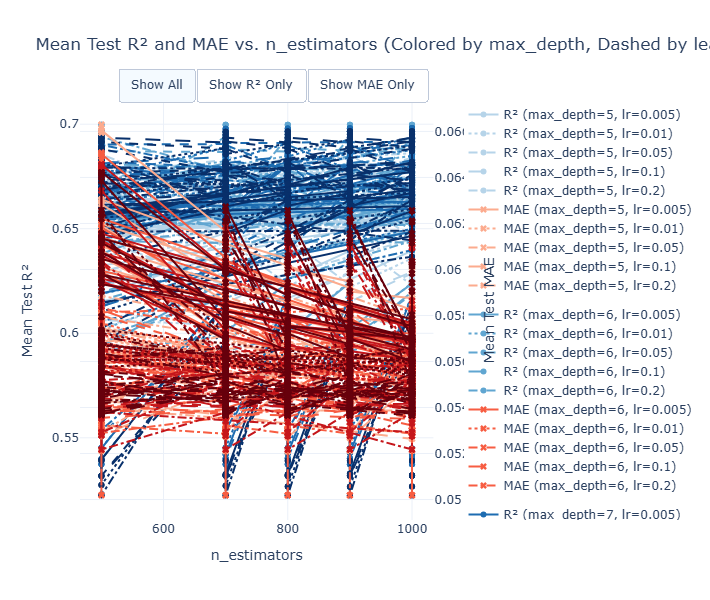

In [7]:
# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Get unique max_depth and learning_rate values
max_depth_values = results_df['max_depth'].unique()
learning_rate_values = results_df['learning_rate'].unique()

# Define colormaps for different shades of blue (R²) and red (MAE)
blue_colors = plt.cm.Blues(np.linspace(0.3, 1, len(max_depth_values)))                        # Shades of blue
blue_colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b, _ in blue_colors]  # Convert to RGB

red_colors = plt.cm.Reds(np.linspace(0.3, 1, len(max_depth_values)))                        # Shades of red
red_colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b, _ in red_colors]  # Convert to RGB

# Define dash styles for different learning rates
dash_styles = ['solid', 'dot', 'dash', 'longdash', 'dashdot']                               # Add more styles if needed

# Add R² traces for each max_depth and learning_rate
for max_depth, color in zip(max_depth_values, blue_colors):
    for learning_rate, dash_style in zip(learning_rate_values, dash_styles):
        subset = results_df[(results_df['max_depth'] == max_depth) & (results_df['learning_rate'] == learning_rate)]
        fig.add_trace(
            go.Scatter(x=subset['n_estimators'], y=subset['mean_test_r2'],
                       name=f'R² (max_depth={max_depth}, lr={learning_rate})',
                       mode='lines+markers', marker=dict(color=color),
                       line=dict(color=color, dash=dash_style), legendgroup=f'max_depth_{max_depth}',  
                       showlegend=True, visible=True ),
            secondary_y=False)

# Add MAE traces for each max_depth and learning_rate
for max_depth, color in zip(max_depth_values, red_colors):
    for learning_rate, dash_style in zip(learning_rate_values, dash_styles):
        subset = results_df[(results_df['max_depth'] == max_depth) & (results_df['learning_rate'] == learning_rate)]
        fig.add_trace(
            go.Scatter(x=subset['n_estimators'], y=subset['mean_test_mae'],
                       name=f'MAE (max_depth={max_depth}, lr={learning_rate})',
                       mode='lines+markers', marker=dict(color=color, symbol='x'),
                       line=dict(color=color, dash=dash_style),
                       legendgroup=f'max_depth_{max_depth}',  
                       showlegend=True, visible=True ),
            secondary_y=True)

fig.update_xaxes(title_text='n_estimators') 
fig.update_yaxes(title_text='Mean Test R²', secondary_y=False)
fig.update_yaxes(title_text='Mean Test MAE', secondary_y=True)

fig.update_layout(updatemenus=[{"type": "buttons",
                                "direction": "left",
                                "buttons": [{"args": [{"visible": [True] * len(fig.data)}],  
                                             "label": "Show All",
                                             "method": "update"},
                                            {"args": [{"visible": [trace.name.startswith('R²') for trace in fig.data]}],  
                                             "label": "Show R² Only",
                                             "method": "update"},
                                            {"args": [{"visible": [trace.name.startswith('MAE') for trace in fig.data]}],  
                                             "label": "Show MAE Only",
                                             "method": "update"}],
                                "pad": {"r": 10, "t": 10},
                                "showactive": True,
                                "x": 0.1, "xanchor": "left", "y": 1.1, "yanchor": "top"}
                              ]
                 )

# Set title and layout
fig.update_layout(title='Mean Test R² and MAE vs. n_estimators (Colored by max_depth, Dashed by learning_rate)',
                  template='plotly_white',
                  showlegend=True,
                  width=1200, height=600)
fig.show()

###  Step 4: Evaluate best hyperparameters on the test set & Plot actual vs predicted

In [10]:
y_pred = best_model.predict(X_test)  # Predict on the test set

# Compute performance metrics 
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
bias = np.mean(y_pred - y_test) 

In [11]:
# Create Dataframe with the actual & predicted values along with other columns    
plotting_df = pd.DataFrame({'Source_ID': groups_test,'Date': dates_test,'Actual_SWCT_1_015': y_test,'Predicted_SWCT_1_015': y_pred})    
source_column = Complete_Data[['Source','Day_of_Year']]
merged_df = plotting_df.merge(source_column, left_index=True, right_index=True, how='left')
merged_df['Source_ID'] = merged_df['Source_ID'].astype('category')

#### Plot scatter plots of Actual vs Predicted SWCT_1_015

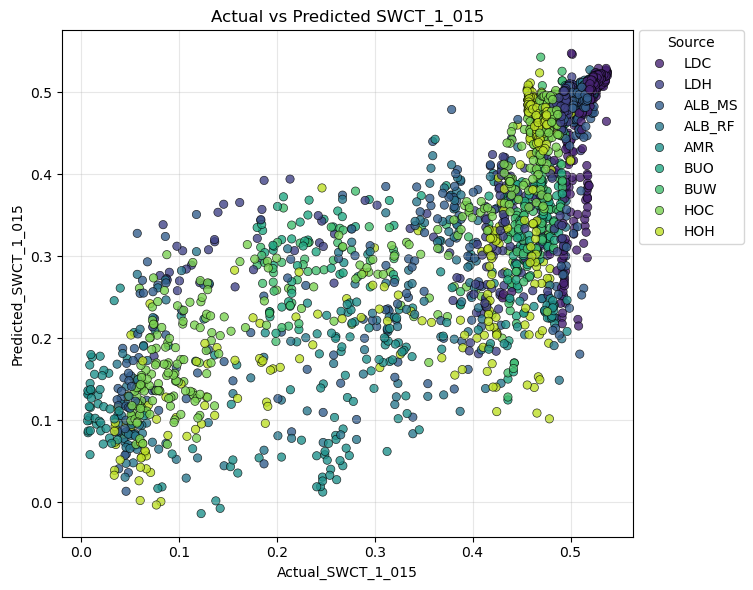

In [12]:
plt.figure(figsize=(9, 6))
sns.scatterplot(data=merged_df, 
                x='Actual_SWCT_1_015', y='Predicted_SWCT_1_015', 
                hue='Source', palette='viridis', edgecolor='k', alpha=0.8)
plt.title('Actual vs Predicted SWCT_1_015')
plt.xlabel('Actual_SWCT_1_015')
plt.ylabel('Predicted_SWCT_1_015')
plt.legend(title='Source',
           bbox_to_anchor=(1.01, 1),  # Position outside the plot 
           loc='upper left',          # Anchor to the upper left
           borderaxespad=0)           # Padding between the plot and legend
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit the legend, Leave space for the legend
plt.show()

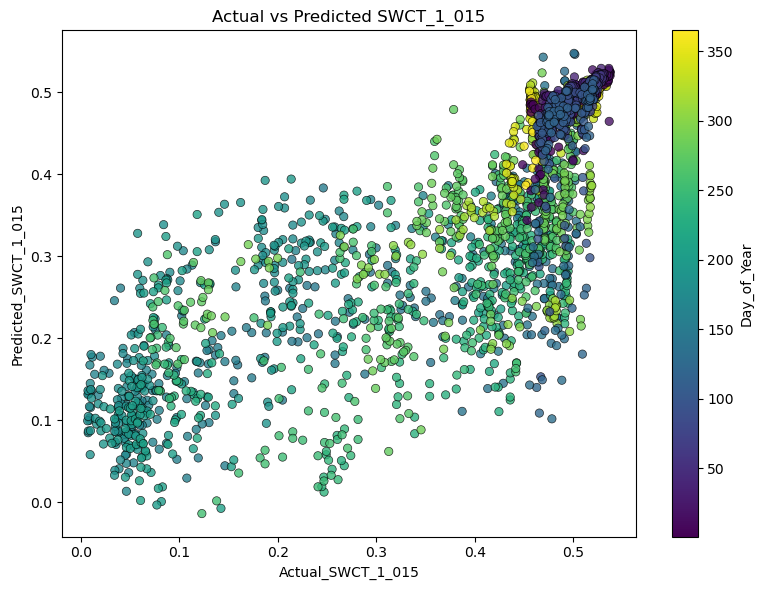

In [13]:
plt.figure(figsize=(8, 6))
sc = sns.scatterplot(data=merged_df,
                     x='Actual_SWCT_1_015', y='Predicted_SWCT_1_015',
                     hue='Day_of_Year', palette='viridis', edgecolor='k', alpha=0.8, legend=False)
norm = Normalize(vmin=merged_df['Day_of_Year'].min(), vmax=merged_df['Day_of_Year'].max())
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=sc.axes)
cbar.set_label('Day_of_Year')
plt.xlabel("Actual_SWCT_1_015")
plt.ylabel("Predicted_SWCT_1_015")
plt.title("Actual vs Predicted SWCT_1_015")
plt.tight_layout()
plt.show()

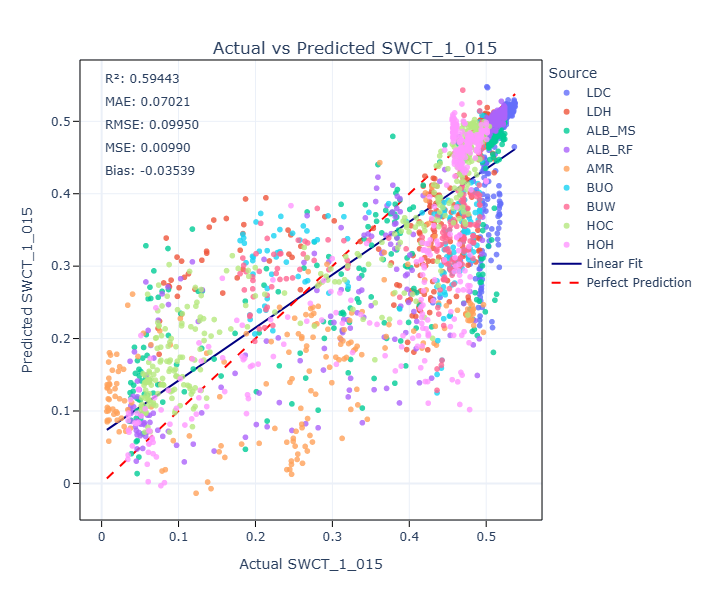

In [14]:
merged_df['Source'] = merged_df['Source'].astype(str)

fig = px.scatter(merged_df, 
                 x='Actual_SWCT_1_015', 
                 y='Predicted_SWCT_1_015', 
                 color='Source',  # Color by Source
                 opacity=0.8)

# Fit a linear regression line
y_test_array = merged_df['Actual_SWCT_1_015'].to_numpy().reshape(-1, 1)
y_pred_array = merged_df['Predicted_SWCT_1_015'].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(y_test_array, y_pred_array)
y_line = reg.predict(y_test_array)

# Add regression and perfect prediction lines
fig.add_trace(go.Scatter(x=merged_df['Actual_SWCT_1_015'], y=y_line.flatten(),
                         mode='lines', line=dict(color='navy'), name='Linear Fit'))
fig.add_trace(go.Scatter(x=[merged_df['Actual_SWCT_1_015'].min(), merged_df['Actual_SWCT_1_015'].max()],
                         y=[merged_df['Actual_SWCT_1_015'].min(), merged_df['Actual_SWCT_1_015'].max()],
                         mode='lines', line=dict(color='red', dash='dash'), name='Perfect Prediction'))

# Add performance metrics
annotations = [
    dict(x=0.05, y=0.98, xref='paper', yref='paper', text=f"R²: {r2:.5f}", showarrow=False, font=dict(size=12)),
    dict(x=0.05, y=0.93, xref='paper', yref='paper', text=f"MAE: {mae:.5f}", showarrow=False, font=dict(size=12)),
    dict(x=0.05, y=0.88, xref='paper', yref='paper', text=f"RMSE: {rmse:.5f}", showarrow=False, font=dict(size=12)),
    dict(x=0.05, y=0.83, xref='paper', yref='paper', text=f"MSE: {mse:.5f}", showarrow=False, font=dict(size=12)),
    dict(x=0.05, y=0.78, xref='paper', yref='paper', text=f"Bias: {bias:.5f}", showarrow=False, font=dict(size=12))
]

fig.update_layout(
    title={'text': "Actual vs Predicted SWCT_1_015", 'y': 0.93, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis_title="Actual SWCT_1_015",
    yaxis_title="Predicted SWCT_1_015",
    annotations=annotations,
    legend=dict(title="Source", x=1.01, y=1, xanchor='left', borderwidth=0),  # Adjust legend position
    template='plotly_white',
    width=800, height=600,
    shapes=[dict(type="rect", xref="paper", yref="paper", x0=0, y0=0, x1=1, y1=1, line=dict(color="black", width=1))],
    xaxis=dict(showline=True, mirror=True, ticks='outside', ticklen=6, tickwidth=1, tickcolor='black'),
    yaxis=dict(showline=True, mirror=True, ticks='outside', ticklen=6, tickwidth=1, tickcolor='black')
)

fig.show()

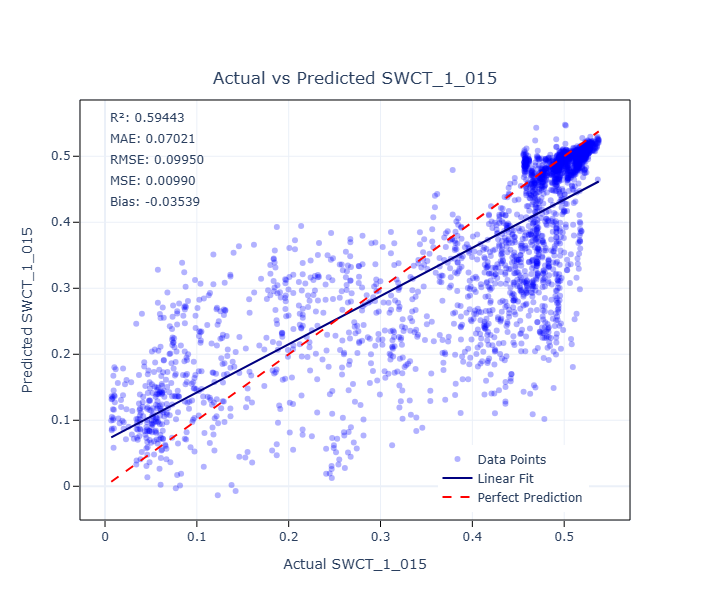

In [15]:
# Convert to 2D arrays for Linear Regression
y_test_array = y_test.to_numpy().reshape(-1, 1)
y_pred_array = y_pred.reshape(-1, 1)

# Fit a linear regression line
reg = LinearRegression().fit(y_test_array, y_pred_array)
y_line = reg.predict(y_test_array)

fig = go.Figure()  
fig.add_trace(go.Scatter(x=y_test,y=y_pred,
                         mode='markers', 
                         marker=dict(color='blue', opacity=0.3),
                         name='Data Points')
             )
fig.add_trace(go.Scatter(x=y_test,y=y_line.flatten(),
                         mode='lines',
                         line=dict(color='navy'),
                         name='Linear Fit')
             )
fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()],
                         y=[y_test.min(), y_test.max()],
                         mode='lines',
                         line=dict(color='red', dash='dash'),
                         name='Perfect Prediction')
             )
annotations = [dict(x=0.05, y=0.98,
                    xref='paper', yref='paper',
                    text=f"R²: {r2:.5f}",
                    showarrow=False, font=dict(size=12)),
               dict(x=0.05, y=0.93,
                    xref='paper', yref='paper',
                    text=f"MAE: {mae:.5f}",
                    showarrow=False, font=dict(size=12)),
dict(x=0.05, y=0.88,
     xref='paper', yref='paper',
     text=f"RMSE: {rmse:.5f}", 
     showarrow=False, font=dict(size=12)),
dict(x=0.05, y=0.83,
     xref='paper', yref='paper',
     text=f"MSE: {mse:.5f}",
     showarrow=False, font=dict(size=12)),
dict(x=0.05, y=0.78,
     xref='paper', yref='paper',
     text=f"Bias: {bias:.5f}",
     showarrow=False, font=dict(size=12))]

fig.update_layout(title={
    'text': "Actual vs Predicted SWCT_1_015",  
    'y': 0.88,'x': 0.5,'xanchor': 'center','yanchor': 'top'},
                  xaxis_title="Actual SWCT_1_015",
                  yaxis_title="Predicted SWCT_1_015",
                  annotations=annotations,
                  legend=dict(x=0.65, y=0.02),
                  template='plotly_white',
                  width=600, height=600,
                  shapes=[dict(type="rect",
                               xref="paper", yref="paper",
                               x0=0, y0=0, x1=1,y1=1,
                               line=dict(color="black", width=1,
                                        ),
                              )
                         ],
                  xaxis=dict(showline=True,mirror=True,
                             ticks='outside', ticklen=6, 
                             tickwidth=1, tickcolor='black'),
                  yaxis=dict(showline=True, mirror=True,
                             ticks='outside',ticklen=6,
                             tickwidth=1, tickcolor='black')
                 )
fig.show()

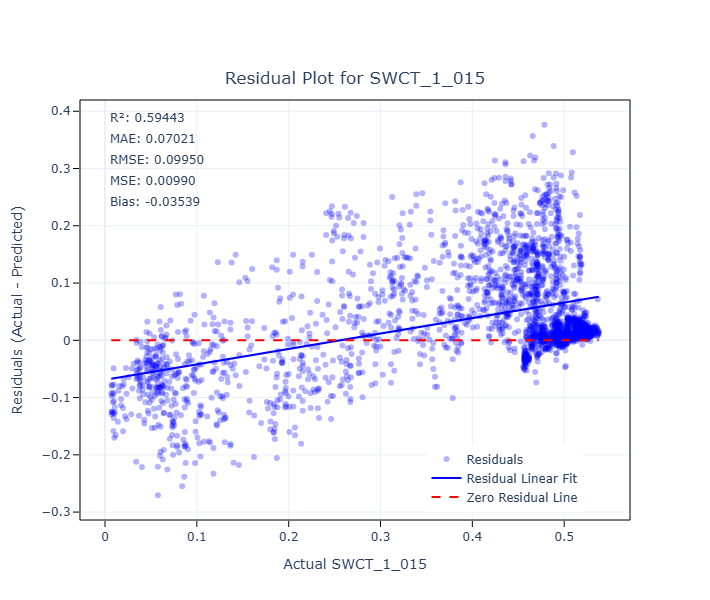

In [16]:
residuals = y_test - y_pred  # Calculate residuals

# Convert to 2D arrays for Linear Regression
y_test_array = y_test.to_numpy().reshape(-1, 1)
residuals_array = residuals.to_numpy().reshape(-1, 1)

# Fit a linear regression line to residuals
reg = LinearRegression().fit(y_test_array, residuals_array)
residual_line = reg.predict(y_test_array)

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test,y=residuals,
                         mode='markers',
                         marker=dict(color='blue', opacity=0.3),
                         name='Residuals'))
fig.add_trace(go.Scatter(x=y_test,y=residual_line.flatten(),
                         mode='lines', line=dict(color='blue'),
                         name='Residual Linear Fit'))
fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()],
                         y=[0, 0], mode='lines',
                         line=dict(color='red', dash='dash'),
                         name='Zero Residual Line'))

annotations = [dict(x=0.05,y=0.98, xref='paper', yref='paper',
                    text=f"R²: {r2:.5f}", showarrow=False,
                    font=dict(size=12)),
               dict(x=0.05,y=0.93, xref='paper',yref='paper',
                    text=f"MAE: {mae:.5f}", showarrow=False,
                    font=dict(size=12)),
dict(x=0.05, y=0.88, xref='paper', yref='paper',
     text=f"RMSE: {rmse:.5f}", showarrow=False,
     font=dict(size=12)),
dict(x=0.05, y=0.83, xref='paper', yref='paper',
     text=f"MSE: {mse:.5f}", showarrow=False,
     font=dict(size=12)),
dict(x=0.05, y=0.78, xref='paper', yref='paper',
     text=f"Bias: {bias:.5f}", showarrow=False,
     font=dict(size=12))]

fig.update_layout(title={'text': "Residual Plot for SWCT_1_015",  
                         'y': 0.88,'x': 0.5,
                         'xanchor': 'center', 'yanchor': 'top'},
                  xaxis_title="Actual SWCT_1_015",
                  yaxis_title="Residuals (Actual - Predicted)",
                  annotations=annotations,
                  legend=dict(x=0.63, y=0.02),
                  template='plotly_white',
                  width=600, height=600,
                  shapes=[dict(type="rect", xref="paper", yref="paper",
                               x0=0, y0=0, x1=1, y1=1,
                               line=dict(color="black",width=1,),
                              )],
                  xaxis=dict(showline=True, mirror=True,
                             ticks='outside', ticklen=6, tickwidth=1,   
                             tickcolor='black'),
                  yaxis=dict(showline=True, mirror=True,    
                             ticks='outside', ticklen=6, tickwidth=1,  
                             tickcolor='black'))
fig.show()

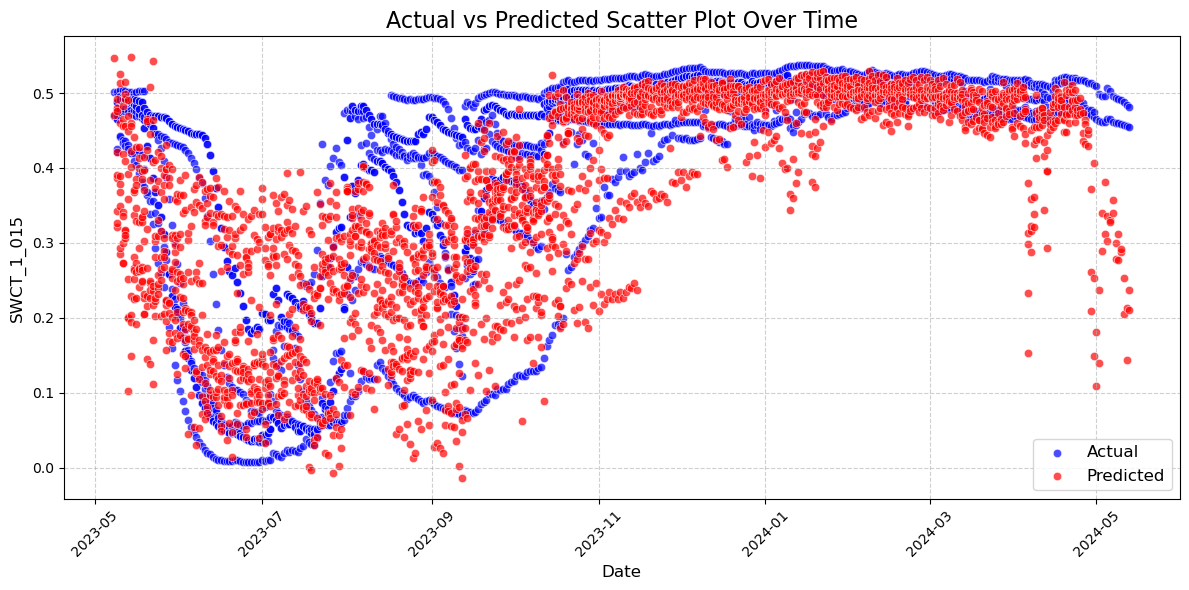

In [17]:
plot_data = pd.DataFrame({'Date': dates_test,'Actual': y_test,'Predicted': y_pred})   # Create a DataFrame for plotting
plot_data = plot_data.sort_values(by='Date')                                          #  Sort the data by Date for clear plotting
X_test
plt.figure(figsize=(12,6))
sns.scatterplot(data=plot_data, x='Date', y='Actual', label='Actual', color='blue', alpha=0.7)
sns.scatterplot(data=plot_data, x='Date', y='Predicted', label='Predicted', color='red', alpha=0.7)

# Add grid and formatting
plt.title('Actual vs Predicted Scatter Plot Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('SWCT_1_015', fontsize=12)  
plt.legend(fontsize=12)
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.6)  

plt.tight_layout()
plt.show()

#### Plot grid search hyperparameter heatmap 

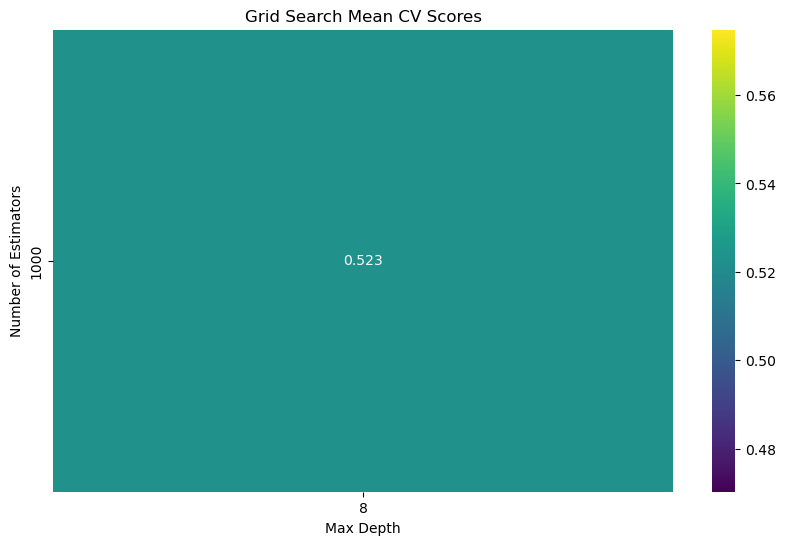

In [19]:
#results = grid_search.cv_results_
#pprint.pprint(results)
# Print type and structure for inspection
#print(f"Type of my_dict: {type(results)}")
#print(f"Keys in my_dict: {results.keys()}")
#print(f"Values in my_dict: {results.values()}")
#print(f"Items in my_dict: {results.items()}")
results = pd.DataFrame(grid_search.cv_results_)
scores = results.pivot_table(
    index='param_xgbregressor__n_estimators',
    columns='param_xgbregressor__max_depth',
    values='mean_test_r2')

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap="viridis")
plt.title("Grid Search Mean CV Scores")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

In [ ]:
iterations = np.arange(1, len(results['mean_test_score']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(iterations, results['mean_test_score'], marker='o', label='Mean Test Score')
plt.fill_between(
    iterations,
    np.array(results['mean_test_score']) - np.array(results['std_test_score']),
    np.array(results['mean_test_score']) + np.array(results['std_test_score']),
    color='gray', alpha=0.2, label='Std Test Score'
)
plt.title('Mean Test Score Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Mean Test Score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Extract fold scores and prepare the dataframe
fold_scores = [f'split{i}_test_score' for i in range(10)]  # Adjust fold count as needed
df = pd.DataFrame(results, columns=fold_scores)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title('Test Scores Across Folds for Each Iteration')
plt.xlabel('Fold')
plt.xticks(rotation=80)
plt.ylabel('Test Score')
plt.grid()
plt.show()